In [ ]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)
# 경고 뜨지 않게
import warnings
warnings.filterwarnings('ignore')

#저장라이브러리
import pickle

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# 데이터를 학습용과 검증용으로 나눈다.
from sklearn.model_selection import train_test_split

import os

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/데이터톤/data/total_gmt5.parquet')
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,5,None,None,None,None,Tuesday
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,5,appliances,environment,water_heater,None,Tuesday
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,5,furniture,living_room,sofa,None,Tuesday
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,5,computers,notebook,None,None,Tuesday
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,5,electronics,smartphone,None,None,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345120463,2020-03-31 23:59:55+00:00,view,1005212,2232732093077520756,construction.tools.light,samsung,178.12,516506125,cdd4bce1-ff8c-49c3-92b3-0c7a209c8b24,2020-04-01,4,construction,tools,light,None,Wednesday
345120464,2020-03-31 23:59:55+00:00,view,1701027,2232732099981345295,appliances.personal.massager,samsung,154.42,572260610,2e16ffb5-996f-40d3-b98e-ddc53b546357,2020-04-01,4,appliances,personal,massager,None,Wednesday
345120465,2020-03-31 23:59:56+00:00,view,2601488,2232732101835227701,None,darina,167.29,523607693,6836d271-ef67-42dc-8756-4ef103e4fbf1,2020-04-01,4,None,None,None,None,Wednesday
345120466,2020-03-31 23:59:56+00:00,view,100006963,2232732099754852875,appliances.personal.massager,yasin,163.16,629229484,c00a1636-dfc2-4e96-a6a3-7fd979e93789,2020-04-01,4,appliances,personal,massager,None,Wednesday


<Figure size 1000x600 with 0 Axes>

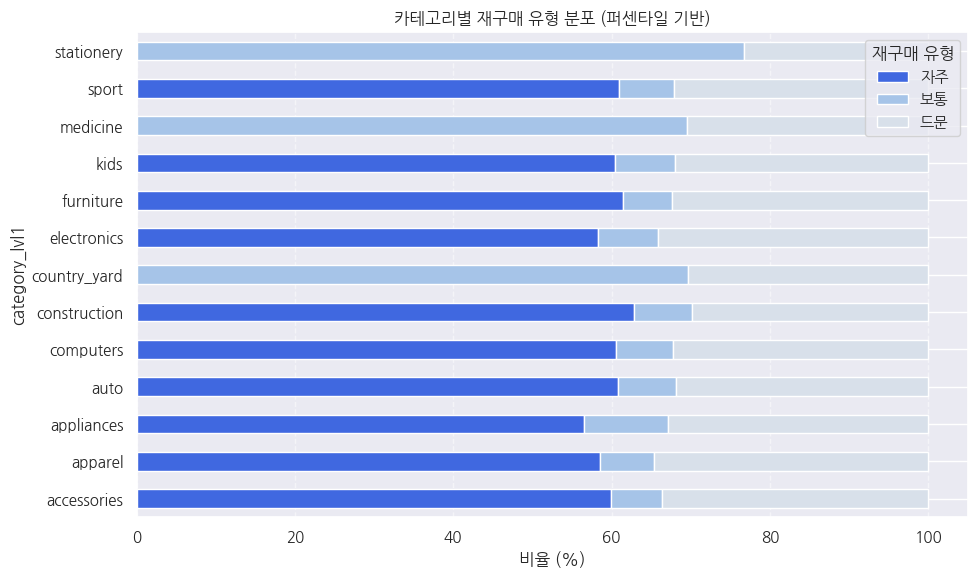

In [ ]:
# ✅ 1. 구매 이벤트 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# ✅ 2. 정렬
df_purchase = df_purchase.sort_values(by=['user_id', 'category_lvl1', 'event_time'])

# ✅ 3. 다음 구매일 계산
df_purchase['next_purchase'] = df_purchase.groupby(['user_id', 'category_lvl1'])['event_time'].shift(-1)

# ✅ 4. 구매 간격 계산
df_purchase['gap_days'] = (df_purchase['next_purchase'] - df_purchase['event_time']).dt.days
df_valid_gap = df_purchase[df_purchase['gap_days'].notna()].copy()

# ✅ 5. 카테고리별 누적분포 기반 등급 라벨링 함수 정의
def assign_repurchase_percentile(df):
    result = df.copy()
    # gap_days 누적 비율 계산
    result['percentile'] = result['gap_days'].rank(pct=True)

    # 기준 구간
    def label(p):
        if p <= 0.33:
            return '자주'
        elif p <= 0.67:
            return '보통'
        else:
            return '드문'

    result['revisit_type'] = result['percentile'].apply(label)
    return result

# ✅ 6. 카테고리별로 적용
df_percentiled = (
    df_valid_gap
    .groupby('category_lvl1', group_keys=False)
    .apply(assign_repurchase_percentile)
)

# ✅ 7. 결과 분포 확인용 피벗
pivot = df_percentiled.groupby(['category_lvl1', 'revisit_type'])['user_id'].count().unstack(fill_value=0)
pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# ✅ 8. 시각화
plt.figure(figsize=(10, 6))
pivot_percent[['자주', '보통', '드문']].plot(
    kind='barh', stacked=True, color=['#4068e0', '#a6c4e8', '#d8e0ea'], figsize=(10, 6)
)
plt.title("카테고리별 재구매 유형 분포 (퍼센타일 기반)")
plt.xlabel("비율 (%)")
plt.legend(title="재구매 유형")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 1. 구매 이벤트 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# 2. 정렬 및 다음 구매일 계산
df_purchase = df_purchase.sort_values(by=['user_id', 'category_lvl1', 'event_time'])
df_purchase['next_purchase'] = df_purchase.groupby(['user_id', 'category_lvl1'])['event_time'].shift(-1)

# 3. 구매 간격 계산
df_purchase['gap_days'] = (df_purchase['next_purchase'] - df_purchase['event_time']).dt.days
df_valid_gap = df_purchase[df_purchase['gap_days'].notna()].copy()

# 4. 카테고리별 분위수 기준 경계 계산 (33%, 67%)
quantiles = (
    df_valid_gap.groupby('category_lvl1')['gap_days']
    .quantile([0.33, 0.67])
    .unstack()
    .rename(columns={0.33: '자주_최대일', 0.67: '보통_최대일'})
    .round(0)
)

# 5. 구간 문자열 생성
def format_range(row):
    q1 = int(row['자주_최대일'])
    q2 = int(row['보통_최대일'])

    return pd.Series({
        '자주': f"≤ {q1}일",
        '보통': f"{q1+1}~{q2}일" if q1 < q2 else f"{q1}일",
        '드문': f"≥ {q2+1}일"
    })

repurchase_range_table = quantiles.apply(format_range, axis=1).reset_index()
repurchase_range_table.columns.name = None

# 결과 출력
print(repurchase_range_table)


   category_lvl1    자주    보통    드문
0    accessories  ≤ 0일  1~2일  ≥ 3일
1        apparel  ≤ 0일  1~2일  ≥ 3일
2     appliances  ≤ 0일  1~2일  ≥ 3일
3           auto  ≤ 0일  1~1일  ≥ 2일
4      computers  ≤ 0일  1~1일  ≥ 2일
5   construction  ≤ 0일  1~1일  ≥ 2일
6   country_yard  ≤ 0일    0일  ≥ 1일
7    electronics  ≤ 0일  1~2일  ≥ 3일
8      furniture  ≤ 0일  1~1일  ≥ 2일
9           kids  ≤ 0일  1~1일  ≥ 2일
10      medicine  ≤ 0일    0일  ≥ 1일
11         sport  ≤ 0일  1~1일  ≥ 2일
12    stationery  ≤ 0일    0일  ≥ 1일


In [ ]:
import pandas as pd

# 1. 구매 이벤트만 추출
purchase_df = df[df['event_type'] == 'purchase'].copy()
purchase_df['event_time'] = pd.to_datetime(purchase_df['event_time'])

# 2. 정렬 및 gap 계산
purchase_df = purchase_df.sort_values(['user_id', 'category_lvl1', 'event_time'])
purchase_df['prev_time'] = purchase_df.groupby(['user_id', 'category_lvl1'])['event_time'].shift(1)
purchase_df['gap_days'] = (purchase_df['event_time'] - purchase_df['prev_time']).dt.days
gap_df = purchase_df.dropna(subset=['gap_days']).copy()

# 3. 고객-카테고리별 평균 gap 계산
user_cat_gap = (
    gap_df.groupby(['user_id', 'category_lvl1'])['gap_days']
    .mean()
    .reset_index(name='avg_repurchase_days')
)

# 4. 분위수 기준 경계 추출 (33%, 66%)
quantiles = (
    user_cat_gap.groupby('category_lvl1')['avg_repurchase_days']
    .quantile([0.33, 0.66])
    .unstack()
    .rename(columns={0.33: 'q33', 0.66: 'q66'})
    .round(0)
)

# 5. 구간 텍스트로 변환
def format_range(row):
    q1 = int(row['q33'])
    q2 = int(row['q66'])

    return pd.Series({
        '자주': f"≤ {q1}일",
        '보통': f"{q1+1}~{q2}일" if q1 != q2 else f"{q1}일",
        '드문': f"≥ {q2+1}일"
    })

repurchase_range_table = quantiles.apply(format_range, axis=1).reset_index()
repurchase_range_table.columns.name = None

# 6. 결과 출력
print(repurchase_range_table)


   category_lvl1    자주    보통    드문
0    accessories  ≤ 0일  1~3일  ≥ 4일
1        apparel  ≤ 0일  1~5일  ≥ 6일
2     appliances  ≤ 0일  1~8일  ≥ 9일
3           auto  ≤ 0일  1~3일  ≥ 4일
4      computers  ≤ 0일  1~4일  ≥ 5일
5   construction  ≤ 0일  1~5일  ≥ 6일
6   country_yard  ≤ 0일  1~1일  ≥ 2일
7    electronics  ≤ 0일  1~6일  ≥ 7일
8      furniture  ≤ 0일  1~4일  ≥ 5일
9           kids  ≤ 0일  1~3일  ≥ 4일
10      medicine  ≤ 0일  1~1일  ≥ 2일
11         sport  ≤ 0일  1~4일  ≥ 5일
12    stationery  ≤ 0일    0일  ≥ 1일


<Figure size 1000x600 with 0 Axes>

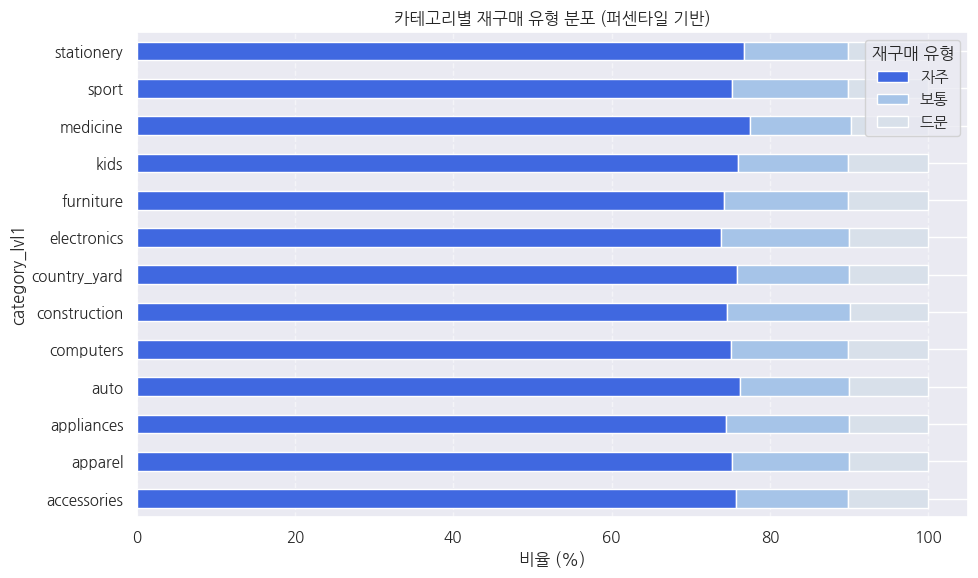

In [ ]:
# ✅ 1. 구매 이벤트 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# ✅ 2. 정렬
df_purchase = df_purchase.sort_values(by=['user_id', 'category_lvl1', 'event_time'])

# ✅ 3. 다음 구매일 계산
df_purchase['next_purchase'] = df_purchase.groupby(['user_id', 'category_lvl1'])['event_time'].shift(-1)

# ✅ 4. 구매 간격 계산
df_purchase['gap_days'] = (df_purchase['next_purchase'] - df_purchase['event_time']).dt.days
df_valid_gap = df_purchase[df_purchase['gap_days'].notna()].copy()

# ✅ 5. 카테고리별 누적분포 기반 등급 라벨링 함수 정의
def assign_repurchase_percentile(df):
    result = df.copy()
    # gap_days 누적 비율 계산
    result['percentile'] = result['gap_days'].rank(pct=True)

    # 기준 구간
    def label(p):
        if p <= 0.75:
            return '자주'
        elif p <= 0.9:
            return '보통'
        else:
            return '드문'

    result['revisit_type'] = result['percentile'].apply(label)
    return result

# ✅ 6. 카테고리별로 적용
df_percentiled = (
    df_valid_gap
    .groupby('category_lvl1', group_keys=False)
    .apply(assign_repurchase_percentile)
)

# ✅ 7. 결과 분포 확인용 피벗
pivot = df_percentiled.groupby(['category_lvl1', 'revisit_type'])['user_id'].count().unstack(fill_value=0)
pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# ✅ 8. 시각화
plt.figure(figsize=(10, 6))
pivot_percent[['자주', '보통', '드문']].plot(
    kind='barh', stacked=True, color=['#4068e0', '#a6c4e8', '#d8e0ea'], figsize=(10, 6)
)
plt.title("카테고리별 재구매 유형 분포 (퍼센타일 기반)")
plt.xlabel("비율 (%)")
plt.legend(title="재구매 유형")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 1. gap_days가 있는 데이터 추출 (이미 전처리된 상태로 가정)
# df_valid_gap: user_id + category_lvl1 + event_time + gap_days

# 2. 분위수 경계값 계산 (카테고리별)
quantiles = (
    df_valid_gap.groupby('category_lvl1')['gap_days']
    .quantile([0.75, 0.9])
    .unstack()
    .rename(columns={0.75: '자주_최대일', 0.9: '보통_최대일'})
    .round(0)
)

# 3. 구간 문자열 생성
def format_range(row):
    q1 = int(row['자주_최대일'])
    q2 = int(row['보통_최대일'])

    return pd.Series({
        '자주': f"≤ {q1}일",
        '보통': f"{q1+1} ~ {q2}일" if q1 < q2 else f"{q1}일",
        '드문': f"≥ {q2+1}일"
    })

# 4. 적용 후 테이블 생성
repurchase_range_table = quantiles.apply(format_range, axis=1).reset_index()
repurchase_range_table.columns.name = None

# 5. 출력
print(repurchase_range_table)


   category_lvl1    자주       보통     드문
0    accessories  ≤ 4일  5 ~ 20일  ≥ 21일
1        apparel  ≤ 4일  5 ~ 22일  ≥ 23일
2     appliances  ≤ 6일  7 ~ 29일  ≥ 30일
3           auto  ≤ 3일  4 ~ 14일  ≥ 15일
4      computers  ≤ 3일  4 ~ 18일  ≥ 19일
5   construction  ≤ 3일  4 ~ 13일  ≥ 14일
6   country_yard  ≤ 1일   2 ~ 9일  ≥ 10일
7    electronics  ≤ 4일  5 ~ 17일  ≥ 18일
8      furniture  ≤ 4일  5 ~ 21일  ≥ 22일
9           kids  ≤ 3일  4 ~ 16일  ≥ 17일
10      medicine  ≤ 1일   2 ~ 7일   ≥ 8일
11         sport  ≤ 3일  4 ~ 17일  ≥ 18일
12    stationery  ≤ 0일  1 ~ 14일  ≥ 15일


In [ ]:
data_by_cat

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([ 0., 43.,  0., ...,  0.,  0.,  0.]),
 array([12.,  0.,  0., ...,  0.,  0.,  0.]),
 array([3., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 2., ..., 0., 0., 0.]),
 array([  9.,   2., 131., ...,   0.,   0.,   0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([11., 41.,  6., ...,  0.,  0.,  0.]),
 array([41.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 22.,  0.,
         0.,  0., 61.,  0.,  5.,  6.,  0.,  9., 28.,  6., 52.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0., 12.,  0.,  3.,  4.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  1.,  9.,  0.,  0.,
         0., 11.,  0.,  0.,  1.,  0., 34.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 86.,  9.,  9.,  0.,  0., 40., 48.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  6.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  

In [ ]:
plot_df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday,next_purchase,gap_days
176804235,2019-12-31 11:30:56+00:00,purchase,15800015,2232732108613223108,sport.trainer,karcher,145.17,128968633,600541a7-4a9b-4007-a1fc-5e0a06abda12,2019-12-31,16,sport,trainer,None,None,Tuesday,2019-12-31 15:30:09+00:00,0.0
224808817,2020-01-27 08:23:51+00:00,purchase,1005130,2232732093077520756,construction.tools.light,apple,1370.43,237470903,80552fa4-c435-49a1-9ef6-7465cefd4bc0,2020-01-27,13,construction,tools,light,None,Monday,2020-01-30 10:06:08+00:00,3.0
322446492,2020-03-16 05:14:56+00:00,purchase,2700325,2232732091307524418,appliances.kitchen.refrigerators,hansa,280.32,237973968,ab967240-3234-4ea4-a19d-e68e2a6f7be6,2020-03-16,10,appliances,kitchen,refrigerators,None,Monday,2020-03-18 05:08:53+00:00,1.0
165887837,2019-12-26 19:13:11+00:00,purchase,3200533,2232732102019777081,apparel.shoes.keds,bosch,262.53,263137999,c3c0475a-0caa-482b-9ac5-5d7855deef9e,2019-12-27,0,apparel,shoes,keds,None,Friday,2019-12-27 17:46:59+00:00,0.0
132593597,2019-12-14 02:58:44+00:00,purchase,18500040,2053013552695869677,electronics.tablet,genius,64.09,267054723,dcf02630-3bdb-4311-8696-5cdca87ec5da,2019-12-14,7,electronics,tablet,None,None,Saturday,2019-12-23 13:36:18+00:00,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345110874,2020-03-31 22:48:49+00:00,purchase,5801255,2232732082390433922,electronics.audio.subwoofer,alpine,90.09,635143907,5889f636-995f-45fa-9d01-6fcf8e418e3d,2020-04-01,3,electronics,audio,subwoofer,None,Wednesday,2020-03-31 22:56:31+00:00,0.0
345112015,2020-03-31 22:56:31+00:00,purchase,5801255,2232732082390433922,electronics.audio.subwoofer,alpine,90.09,635143907,5889f636-995f-45fa-9d01-6fcf8e418e3d,2020-04-01,3,electronics,audio,subwoofer,None,Wednesday,2020-03-31 22:58:02+00:00,0.0
345105764,2020-03-31 22:20:00+00:00,purchase,1005160,2232732093077520756,construction.tools.light,xiaomi,192.28,635147550,f8094a17-f523-4942-bf79-97cbcc6d239e,2020-04-01,3,construction,tools,light,None,Wednesday,2020-03-31 22:21:52+00:00,0.0
345118415,2020-03-31 23:44:28+00:00,purchase,9300034,2232732104494416497,apparel.shoes,sony,102.71,635158569,6d8e94e7-6bdb-4050-9a37-4dc500c87df3,2020-04-01,4,apparel,shoes,None,None,Wednesday,2020-03-31 23:48:47+00:00,0.0


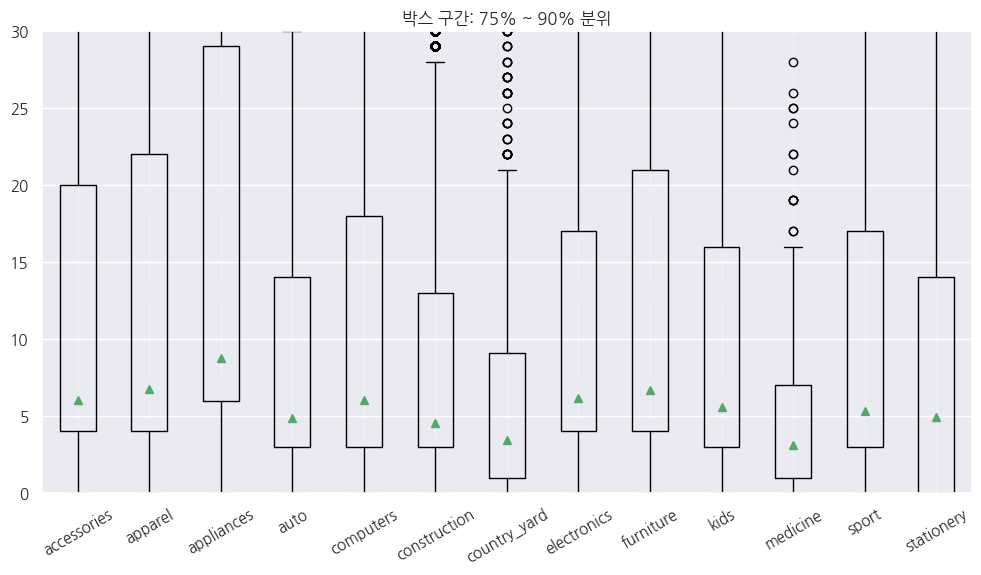

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 0) 전제: df_valid_gap 에 ['category_lvl1', 'gap_days'] 가 있음
# ─────────────────────────────────────────────────────────────

# 선택: 너무 적은 표본 카테고리는 제외(예: 20건 미만)
min_n = 20
cat_counts = df_valid_gap.groupby('category_lvl1')['gap_days'].size()
valid_cats = cat_counts[cat_counts >= min_n].index.tolist()

plot_df = df_valid_gap[df_valid_gap['category_lvl1'].isin(valid_cats)].copy()

# 카테고리 정렬(중앙값 오름차순)
order = (
    plot_df.groupby('category_lvl1')['gap_days']
    .median()
    .sort_values()
    .index
    .tolist()
)

# 카테고리별 데이터 리스트(박스/바이올린 공용)
data_by_cat = [plot_df.loc[plot_df['category_lvl1'] == c, 'gap_days'].dropna().values
               for c in order]

# ─────────────────────────────────────────────────────────────
# 1) 박스플롯
# ─────────────────────────────────────────────────────────────
# import numpy as np

stats = []
for label, arr in zip(order, data_by_cat):
    # 분위 계산
    q1 = np.percentile(arr, 75)   # 기존 25% 대신 75%
    q3 = np.percentile(arr, 90)   # 기존 75% 대신 90%
    median = np.median(arr)
    mean = np.mean(arr)
    iqr = q3 - q1

    # whisker 계산
    whislo = np.min(arr[arr >= q1 - 1.5 * iqr])
    whishi = np.max(arr[arr <= q3 + 1.5 * iqr])
    fliers = arr[(arr < whislo) | (arr > whishi)]

    stats.append({
        'med': median,
        'mean' : mean,
        'q1': q1,
        'q3': q3,
        'whislo': whislo,
        'whishi': whishi,
        'fliers': fliers,
        'label' : label
    })

fig, ax = plt.subplots(figsize=(12, 6))
ax.bxp(stats, showmeans=True)
ax.set_title("박스 구간: 75% ~ 90% 분위")
ax.tick_params(axis='x', rotation=30)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.ylim(0, 30)
plt.show()


# ─────────────────────────────────────────────────────────────
# 2) 바이올린 플롯
# ─────────────────────────────────────────────────────────────
# plt.figure(figsize=(12, 6))
# vp = plt.violinplot(
#     data_by_cat,
#     showmeans=True,
#     showextrema=True,
#     showmedians=False
# )

# positions = np.arange(1, len(order) + 1)
# plt.xticks(positions, order, rotation=30, ha='right')
# plt.title('카테고리별 재구매 간격(gap_days) - 바이올린 플롯')
# plt.ylabel('gap_days (days)')
# plt.grid(axis='y', linestyle='--', alpha=0.4)
# plt.ylim(0, 40)

# plt.tight_layout()
# plt.show()


In [ ]:
import pandas as pd

df_rules = pd.DataFrame({
    'category_lvl1': [
        'accessories', 'apparel', 'appliances', 'auto', 'computers',
        'construction', 'country_yard', 'electronics', 'furniture',
        'kids', 'medicine', 'sport', 'stationery'
    ],
    '자주': [
        '≤ 4일', '≤ 4일', '≤ 6일', '≤ 3일', '≤ 3일',
        '≤ 3일', '≤ 1일', '≤ 5일', '≤ 4일',
        '≤ 2일', '≤ 1일', '≤ 3일', '≤ 0일'
    ],
    '보통': [
        '5 ~ 20일', '5 ~ 22일', '7 ~ 29일', '4 ~ 14일', '4 ~ 18일',
        '4 ~ 13일', '2 ~ 9일', '6 ~ 17일', '5 ~ 22일',
        '3 ~ 16일', '2 ~ 7일', '4 ~ 17일', '1 ~ 14일'
    ],
    '드문': [
        '≥ 21일', '≥ 23일', '≥ 30일', '≥ 15일', '≥ 19일',
        '≥ 14일', '≥ 10일', '≥ 18일', '≥ 23일',
        '≥ 17일', '≥ 8일', '≥ 18일', '≥ 15일'
    ]
})


In [ ]:
import pandas as pd

# ✅ 0. 기준표 생성 (df_rules)
df_rules = pd.DataFrame({
    'category_lvl1': [
        'accessories', 'apparel', 'appliances', 'auto', 'computers',
        'construction', 'country_yard', 'electronics', 'furniture',
        'kids', 'medicine', 'sport', 'stationery'
    ],
    '자주': [
        '≤ 4일', '≤ 4일', '≤ 6일', '≤ 3일', '≤ 3일',
        '≤ 3일', '≤ 1일', '≤ 5일', '≤ 4일',
        '≤ 2일', '≤ 1일', '≤ 3일', '≤ 0일'
    ],
    '보통': [
        '5 ~ 20일', '5 ~ 22일', '7 ~ 29일', '4 ~ 14일', '4 ~ 18일',
        '4 ~ 13일', '2 ~ 9일', '6 ~ 17일', '5 ~ 22일',
        '3 ~ 16일', '2 ~ 7일', '4 ~ 17일', '1 ~ 14일'
    ],
    '드문': [
        '≥ 21일', '≥ 23일', '≥ 30일', '≥ 15일', '≥ 19일',
        '≥ 14일', '≥ 10일', '≥ 18일', '≥ 23일',
        '≥ 17일', '≥ 8일', '≥ 18일', '≥ 15일'
    ]
})

# ✅ 1. 구매 이벤트 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# ✅ 2. 고객별 구매 횟수 계산
purchase_counts = df_purchase.groupby('user_id').size()

# ✅ 3. gap_days 계산 (user_id + category_lvl1)
df_purchase = df_purchase.sort_values(by=['user_id', 'category_lvl1', 'event_time'])
df_purchase['next_time'] = df_purchase.groupby(['user_id', 'category_lvl1'])['event_time'].shift(-1)
df_purchase['gap_days'] = (df_purchase['next_time'] - df_purchase['event_time']).dt.days
df_gaps = df_purchase.dropna(subset=['gap_days']).copy()

# ✅ 4. 기준표 파싱 → 수치형 구간 테이블 만들기
def parse_rule(row):
    cat = row['category_lvl1']
    max1 = int(row['자주'].split('≤')[1].replace('일', '').strip())
    min2, max2 = [int(s.replace('일', '').strip()) for s in row['보통'].split('~')]
    min3 = int(row['드문'].split('≥')[1].replace('일', '').strip())
    return pd.Series({'category_lvl1': cat, '자주_max': max1, '보통_min': min2, '보통_max': max2, '드문_min': min3})

df_rules_clean = df_rules.apply(parse_rule, axis=1)

# ✅ 5. gap_days → 재구매_기간 분류
def classify_gap(row):
    rule = df_rules_clean[df_rules_clean['category_lvl1'] == row['category_lvl1']]
    if rule.empty:
        return None
    r = rule.iloc[0]
    g = row['gap_days']
    if g <= r['자주_max']:
        return '자주'
    elif r['보통_min'] <= g <= r['보통_max']:
        return '보통'
    elif g >= r['드문_min']:
        return '드문'
    else:
        return None

df_gaps['재구매_기간'] = df_gaps.apply(classify_gap, axis=1)

# ✅ 6. 유저별 재구매_기간 대표값 추출
user_period = df_gaps.groupby('user_id')['재구매_기간'].first().reset_index()

# ✅ 7. 원본 데이터 기준 유저 목록
df_users = df[['user_id']].drop_duplicates().copy()

# ✅ 8. 재구매_기간 할당 함수
def assign_label(uid):
    if uid not in purchase_counts:
        return '미구매'
    elif purchase_counts[uid] == 1:
        return '한번구매'
    else:
        label = user_period[user_period['user_id'] == uid]['재구매_기간']
        return label.iloc[0] if not label.empty else '한번구매'

# ✅ 9. 최종 재구매_기간 컬럼 생성
df_users['재구매_기간'] = df_users['user_id'].apply(assign_label)

# ✅ 10. 원래 데이터에 병합
df_final = df.merge(df_users, on='user_id', how='left')

# ✅ 결과 확인
print(df_final[['user_id', 'event_type', 'category_lvl1', '재구매_기간']].head())


     user_id event_type category_lvl1 재구매_기간
0  541312140       view          None   한번구매
1  554748717       view    appliances    미구매
2  519107250       view     furniture    미구매
3  550050854       view     computers    미구매
4  535871217       view   electronics    미구매


In [ ]:
df_final

,user_id,재구매_기간
0,541312140,한번구매
1,554748717,미구매
2,519107250,미구매
3,550050854,미구매
4,535871217,미구매
...,...,...
345120334,635166085,미구매
345120343,635166340,미구매
345120382,614146688,미구매
345120408,635166083,미구매


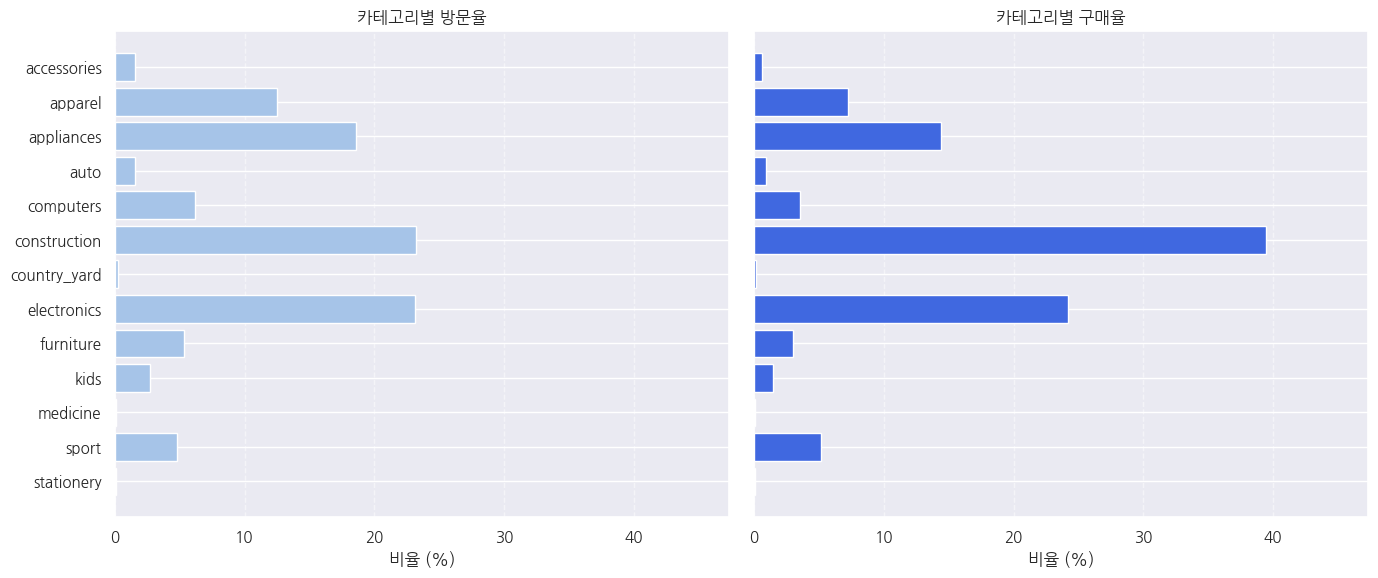

In [ ]:
# 🔹 이벤트 타입 기준 필터링
views     = df[df['event_type'] == 'view']
purchases = df[df['event_type'] == 'purchase']

# 🔹 카테고리별 방문 수 및 구매 수
visit_counts    = views['category_lvl1'].value_counts().sort_index()
purchase_counts = purchases['category_lvl1'].value_counts().sort_index()

# 🔹 카테고리 이름 통일
categories = sorted(set(visit_counts.index).union(set(purchase_counts.index)))

visit_counts = visit_counts.reindex(categories, fill_value=0)
purchase_counts = purchase_counts.reindex(categories, fill_value=0)

# 🔹 비율 계산 (%)
visit_rate    = 100 * visit_counts / visit_counts.sum()
purchase_rate = 100 * purchase_counts / purchase_counts.sum()

# 🔹 시각화 (subplot 양옆)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# ▶ 방문율 막대그래프
axes[0].barh(categories, visit_rate, color='#a6c4e8')
axes[0].set_title('카테고리별 방문율')
axes[0].set_xlabel('비율 (%)')
axes[0].invert_yaxis()  # 높은 비율 위로

# ▶ 구매율 막대그래프
axes[1].barh(categories, purchase_rate, color='#4068e0')
axes[1].set_title('카테고리별 구매율')
axes[1].set_xlabel('비율 (%)')

# 스타일 개선
for ax in axes:
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(0, max(visit_rate.max(), purchase_rate.max()) * 1.2)

plt.tight_layout()
plt.show()


# ✅ 기존 기준 자주/보통/드문 등급 적용

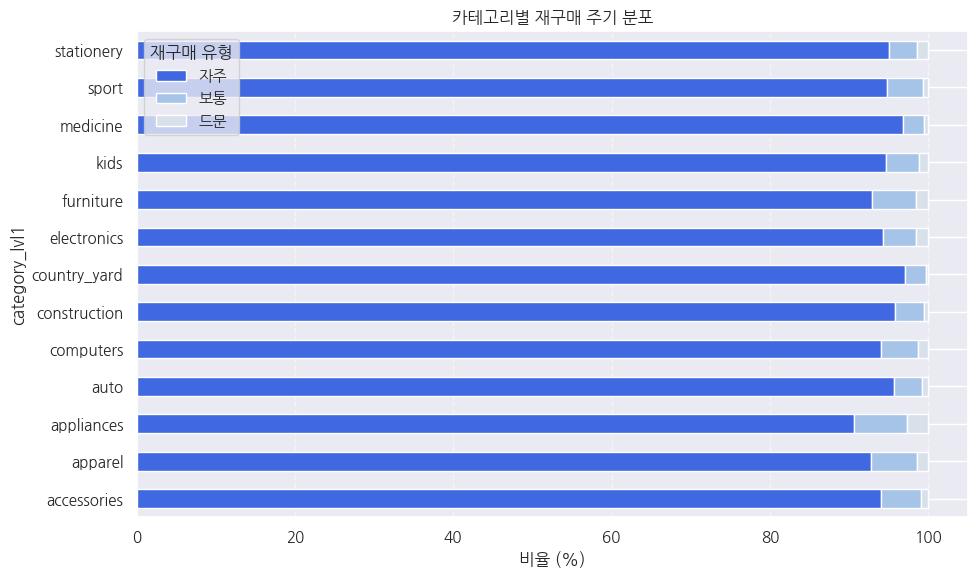

In [ ]:
# Step 1: 구매 데이터만 추출
purchases = df[df['event_type'] == 'purchase'].copy()

# Step 2: 사용자+카테고리별 정렬
purchases = purchases.sort_values(by=['user_id', 'category_lvl1', 'event_time'])

# Step 3: 재구매 간격(일 단위) 계산
purchases['prev_purchase'] = purchases.groupby(['user_id', 'category_lvl1'])['event_time'].shift()
purchases['days_since_last'] = (purchases['event_time'] - purchases['prev_purchase']).dt.days

# Step 4: 첫 구매 제외하고 유효한 재구매만 필터링
valid_repurchase = purchases[~purchases['days_since_last'].isna()].copy()

# Step 5: 재구매 주기 구간화
def classify_gap(days):
    if days <= 30:
        return '자주'
    elif days <= 75:
        return '보통'
    else:
        return '드문'

valid_repurchase['revisit_type'] = valid_repurchase['days_since_last'].apply(classify_gap)

# Step 6: 카테고리별 재구매 구간 비율 계산
pivot = valid_repurchase.groupby(['category_lvl1', 'revisit_type'])['user_id'].count().unstack(fill_value=0)

# 비율로 변환 (%)
pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Step 7: 시각화 (Stacked Bar)
colors = {
    '자주': '#4068e0',
    '보통': '#a6c4e8',
    '드문': '#d8e0ea'
}

pivot_percent = pivot_percent[['자주', '보통', '드문']]  # 순서 정렬

pivot_percent.plot(kind='barh', stacked=True, color=[colors[c] for c in pivot_percent.columns],
                   figsize=(10, 6))

plt.xlabel('비율 (%)')
plt.title('카테고리별 재구매 주기 분포')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title='재구매 유형')
plt.tight_layout()
plt.show()

# ✅ 카테고리별 사분위수 확인 및 등급기준 재산정

<Figure size 1000x600 with 0 Axes>

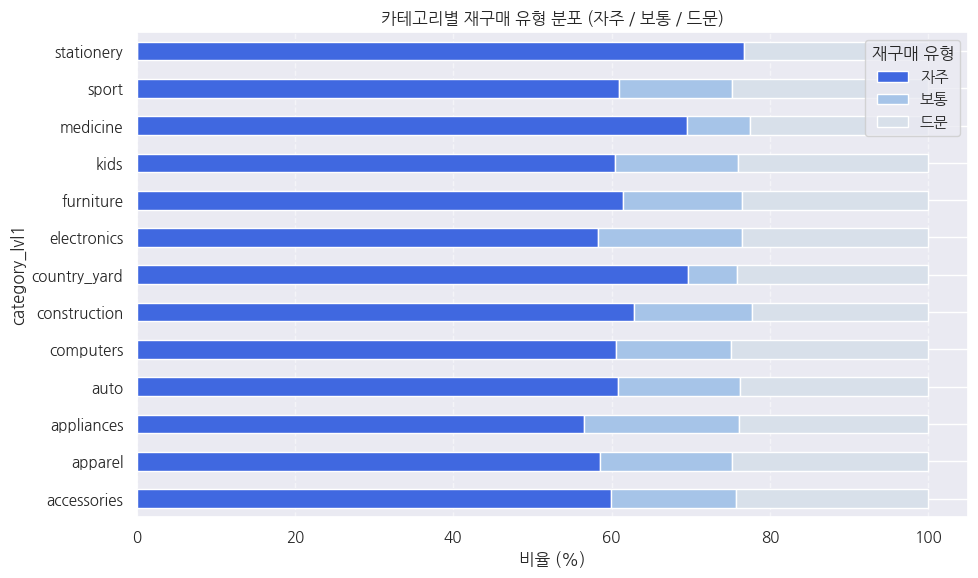

In [ ]:
# ✅ 1. 구매 이벤트 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()

# ✅ 2. 정렬
df_purchase = df_purchase.sort_values(by=['user_id', 'category_lvl1', 'event_time'])

# ✅ 3. 다음 구매일 계산
df_purchase['next_purchase'] = df_purchase.groupby(['user_id', 'category_lvl1'])['event_time'].shift(-1)

# ✅ 4. 구매 간격 계산 (일 단위)
df_purchase['gap_days'] = (df_purchase['next_purchase'] - df_purchase['event_time']).dt.days

# ✅ 5. 재구매가 존재하는 데이터만 필터링
df_valid_gap = df_purchase[df_purchase['gap_days'].notna()].copy()

# ✅ 6. 재구매 이력이 존재하는 카테고리 추출
valid_categories = df_valid_gap['category_lvl1'].value_counts()
valid_categories = valid_categories[valid_categories > 0].index.tolist()
df_valid_gap = df_valid_gap[df_valid_gap['category_lvl1'].isin(valid_categories)]

# ✅ 7. 카테고리별 Q1/Q2/Q3 사분위수 계산
quantiles_by_category = (
    df_valid_gap.groupby('category_lvl1')['gap_days']
    .quantile([0.25, 0.5, 0.75])
    .unstack()
    .rename(columns={0.25: 'Q1 (자주)', 0.5: 'Q2 (보통)', 0.75: 'Q3 (드문)'})
    .round(1)
)

# ✅ 8. 각 카테고리별 맞춤 기준 사전 생성
revisit_bins = {}
for cat in quantiles_by_category.index:
    q1 = quantiles_by_category.loc[cat, 'Q1 (자주)']
    q3 = quantiles_by_category.loc[cat, 'Q3 (드문)']
    revisit_bins[cat] = {
        '자주': q1,
        '보통': q3
    }

# ✅ 9. gap_days 기준으로 등급 분류
def classify_repurchase(row):
    cat = row['category_lvl1']
    gap = row['gap_days']
    if cat in revisit_bins:
        if gap <= revisit_bins[cat]['자주']:
            return '자주'
        elif gap <= revisit_bins[cat]['보통']:
            return '보통'
        else:
            return '드문'
    else:
        return '미정'

df_valid_gap['revisit_type'] = df_valid_gap.apply(classify_repurchase, axis=1)

# ✅ 10. 분포 시각화 (카테고리별 재구매 유형 비율)
pivot = df_valid_gap.groupby(['category_lvl1', 'revisit_type'])['user_id'].count().unstack(fill_value=0)
pivot = pivot[['자주', '보통', '드문']] if set(['자주','보통','드문']).issubset(pivot.columns) else pivot

pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# ✅ 11. 시각화
plt.figure(figsize=(10, 6))
pivot_percent.plot(kind='barh', stacked=True,
                   color=['#4068e0', '#a6c4e8', '#d8e0ea'],
                   figsize=(10, 6))
plt.title("카테고리별 재구매 유형 분포 (자주 / 보통 / 드문)")
plt.xlabel("비율 (%)")
plt.legend(title="재구매 유형")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


| 카테고리          | 자주   | 보통    | 드문   |
| ------------- | ---- | ----- | ---- |
| accessories   | ≤ 2일 | 3\~4일 | ≥ 5일 |
| apparel       | ≤ 2일 | 3\~4일 | ≥ 5일 |
| appliances    | ≤ 3일 | 4\~6일 | ≥ 7일 |
| auto          | ≤ 2일 | 3일    | ≥ 4일 |
| computers     | ≤ 2일 | 3일    | ≥ 4일 |
| construction  | ≤ 2일 | 3일    | ≥ 4일 |
| country\_yard | ≤ 0일 | 1일    | ≥ 2일 |
| electronics   | ≤ 2일 | 3\~4일 | ≥ 5일 |
| furniture     | ≤ 2일 | 3\~4일 | ≥ 5일 |
| kids          | ≤ 2일 | 3일    | ≥ 4일 |
| medicine      | ≤ 0일 | 1일    | ≥ 2일 |
| sport         | ≤ 2일 | 3일    | ≥ 4일 |
| stationery    | ≤ 0일 | 0일    | ≥ 1일 |


In [ ]:
# 1. 등급별 유저 수 집계 (카테고리 x 등급)
revisit_counts = df_valid_gap.groupby(['category_lvl1', 'revisit_type'])['user_id'].count().unstack(fill_value=0)

# 2. 비율(%)로 변환
revisit_percent = revisit_counts.div(revisit_counts.sum(axis=1), axis=0) * 100
revisit_percent = revisit_percent[['자주', '보통', '드문']]  # 열 순서 고정
revisit_percent = revisit_percent.round(1)  # 보기 좋게 반올림

pd.set_option('display.max_rows', 50)
display(revisit_percent)


revisit_type,자주,보통,드문
category_lvl1,,,
accessories,59.9,15.7,24.4
apparel,58.5,16.7,24.9
appliances,56.5,19.6,23.9
auto,60.9,15.3,23.8
computers,60.6,14.5,24.9
construction,62.8,14.9,22.3
country_yard,69.7,6.1,24.2
electronics,58.3,18.2,23.5
furniture,61.5,15.0,23.6


- 전체적으로는 균형적임
- 일부 카테고리는 편향이 있음(stationery)

# 첫 구매 이후 재구매 비율(카테고리별)

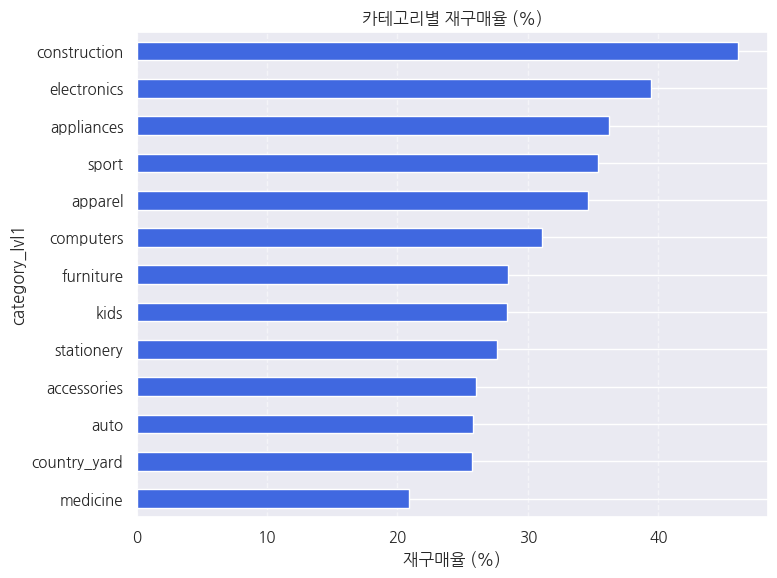

In [ ]:
# 사용자별 카테고리별 구매 횟수
user_cat_counts = df[df['event_type'] == 'purchase'].groupby(['user_id', 'category_lvl1'])['event_time'].count().reset_index(name='purchase_count')

# 재구매 유무 플래그
user_cat_counts['repurchased'] = (user_cat_counts['purchase_count'] > 1).astype(int)

# 카테고리별 재구매율
repurchase_rate = user_cat_counts.groupby('category_lvl1')['repurchased'].mean().mul(100).round(1).sort_values(ascending=False)

# 시각화
repurchase_rate.plot(kind='barh', figsize=(8,6), color='#4068e0')
plt.title('카테고리별 재구매율 (%)')
plt.xlabel('재구매율 (%)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


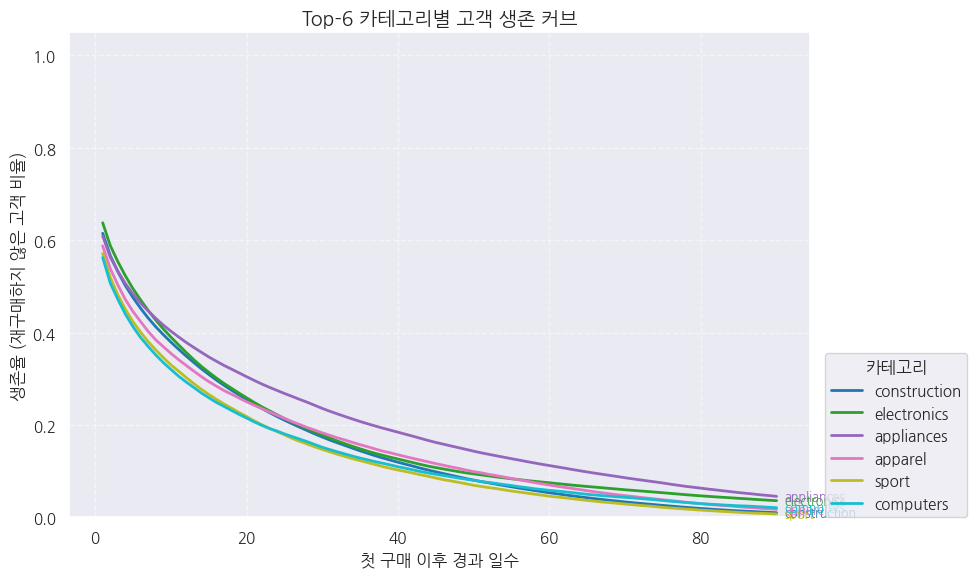

In [ ]:
import matplotlib.cm as cm

# -------------------------------
# 설정
# -------------------------------
top_n = 6
max_days = 90
min_user_threshold = 50

# -------------------------------
# 데이터 준비
# -------------------------------
retention_df = df_valid_gap[['user_id', 'category_lvl1', 'gap_days']].copy()
category_counts = retention_df['category_lvl1'].value_counts()
top_categories = category_counts[category_counts >= min_user_threshold].head(top_n).index.tolist()

# -------------------------------
# 생존 커브 계산
# -------------------------------
days = np.arange(1, max_days + 1)
survival_curves = {}

for cat in top_categories:
    cat_data = retention_df[retention_df['category_lvl1'] == cat]
    total_users = cat_data['user_id'].nunique()
    survival = []
    for d in days:
        still_alive = cat_data[cat_data['gap_days'] >= d]['user_id'].nunique()
        survival.append(still_alive / total_users if total_users else 0)
    survival_curves[cat] = survival

# -------------------------------
# 시각화 (그래프 1장)
# -------------------------------
plt.figure(figsize=(10, 6))
cmap = cm.get_cmap('tab10', top_n)

for i, (cat, curve) in enumerate(survival_curves.items()):
    color = cmap(i)
    plt.plot(days, curve, label=cat, linewidth=2, color=color)
    # 선 끝에 카테고리명 추가 (선택사항)
    plt.text(days[-1]+1, curve[-1], cat, va='center', fontsize=9, color=color)

# ✅ 범례 추가
plt.legend(title="카테고리", loc='lower left', bbox_to_anchor=(1.02, 0), borderaxespad=0.)
plt.title(f"Top-{top_n} 카테고리별 고객 생존 커브", fontsize=14)
plt.xlabel("첫 구매 이후 경과 일수")
plt.ylabel("생존율 (재구매하지 않은 고객 비율)")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# 1. 총 구매금액 계산
df_purchase = df[df['event_type'] == 'purchase'].copy()
user_total = df_purchase.groupby('user_id')['price'].sum().rename('total_spent').reset_index()

# 2. quantile로 등급 구간 나누기
user_total['spending_grade'] = pd.qcut(
    user_total['total_spent'],
    q=[0, 0.3, 0.7, 0.9, 1.0],
    labels=['저관여', '일반', '우수', 'VIP']
)

# 3. 원본 df에 병합
df = df.merge(user_total[['user_id', 'spending_grade']], on='user_id', how='left')
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday,spending_grade
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,5,None,None,None,None,Tuesday,저관여
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,5,appliances,environment,water_heater,None,Tuesday,NaN
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,5,furniture,living_room,sofa,None,Tuesday,NaN
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,5,computers,notebook,None,None,Tuesday,NaN
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,5,electronics,smartphone,None,None,Tuesday,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345120463,2020-03-31 23:59:55+00:00,view,1005212,2232732093077520756,construction.tools.light,samsung,178.12,516506125,cdd4bce1-ff8c-49c3-92b3-0c7a209c8b24,2020-04-01,4,construction,tools,light,None,Wednesday,일반
345120464,2020-03-31 23:59:55+00:00,view,1701027,2232732099981345295,appliances.personal.massager,samsung,154.42,572260610,2e16ffb5-996f-40d3-b98e-ddc53b546357,2020-04-01,4,appliances,personal,massager,None,Wednesday,NaN
345120465,2020-03-31 23:59:56+00:00,view,2601488,2232732101835227701,None,darina,167.29,523607693,6836d271-ef67-42dc-8756-4ef103e4fbf1,2020-04-01,4,None,None,None,None,Wednesday,우수
345120466,2020-03-31 23:59:56+00:00,view,100006963,2232732099754852875,appliances.personal.massager,yasin,163.16,629229484,c00a1636-dfc2-4e96-a6a3-7fd979e93789,2020-04-01,4,appliances,personal,massager,None,Wednesday,VIP


In [ ]:
# 등급 구간 기준 출력
quantile_bins = user_total['total_spent'].quantile([0.3, 0.7, 0.9]).round(2)
print("등급 기준 금액:")
print(quantile_bins)


등급 기준 금액:
0.3     170.66
0.7     720.48
0.9    2084.90
Name: total_spent, dtype: float64


In [ ]:
df['spending_grade'] = df['spending_grade'].cat.add_categories('미구매').fillna('미구매')
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday,spending_grade
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,5,None,None,None,None,Tuesday,저관여
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,5,appliances,environment,water_heater,None,Tuesday,미구매
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,5,furniture,living_room,sofa,None,Tuesday,미구매
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,5,computers,notebook,None,None,Tuesday,미구매
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,5,electronics,smartphone,None,None,Tuesday,미구매
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345120463,2020-03-31 23:59:55+00:00,view,1005212,2232732093077520756,construction.tools.light,samsung,178.12,516506125,cdd4bce1-ff8c-49c3-92b3-0c7a209c8b24,2020-04-01,4,construction,tools,light,None,Wednesday,일반
345120464,2020-03-31 23:59:55+00:00,view,1701027,2232732099981345295,appliances.personal.massager,samsung,154.42,572260610,2e16ffb5-996f-40d3-b98e-ddc53b546357,2020-04-01,4,appliances,personal,massager,None,Wednesday,미구매
345120465,2020-03-31 23:59:56+00:00,view,2601488,2232732101835227701,None,darina,167.29,523607693,6836d271-ef67-42dc-8756-4ef103e4fbf1,2020-04-01,4,None,None,None,None,Wednesday,우수
345120466,2020-03-31 23:59:56+00:00,view,100006963,2232732099754852875,appliances.personal.massager,yasin,163.16,629229484,c00a1636-dfc2-4e96-a6a3-7fd979e93789,2020-04-01,4,appliances,personal,massager,None,Wednesday,VIP


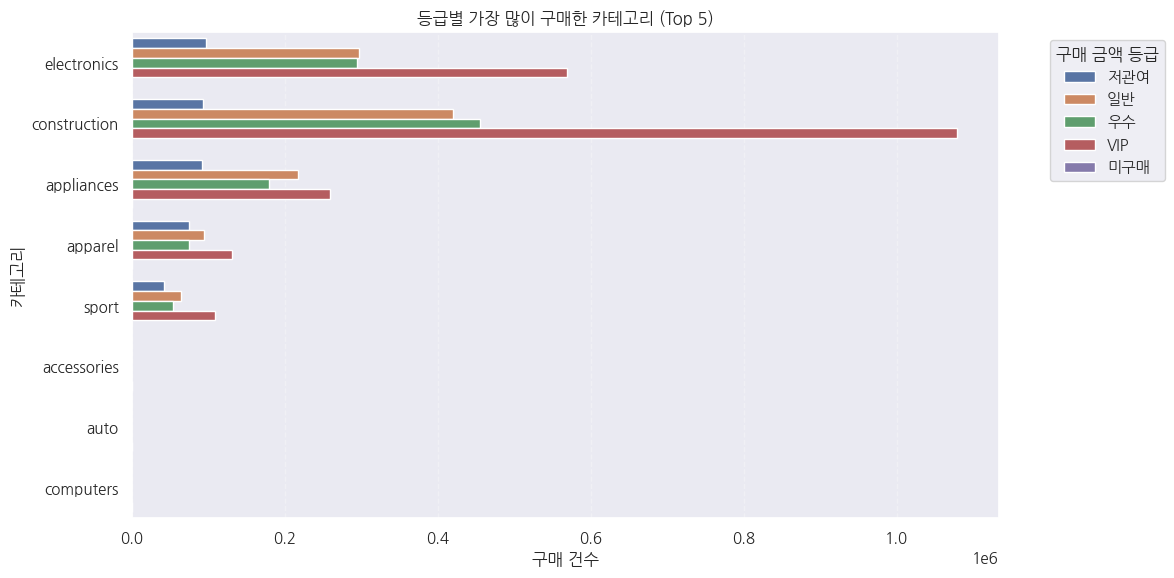

In [ ]:
# 1. 구매 데이터에서 등급 & 카테고리별 구매 수
purchase_df = df[df['event_type'] == 'purchase'].copy()
grouped = (
    purchase_df.groupby(['spending_grade', 'category_lvl1'])
    .size()
    .reset_index(name='purchase_count')
)

# 2. 각 등급별 Top-N 카테고리 (예: 상위 5개)
top_n = 5
top_categories = (
    grouped.sort_values(['spending_grade', 'purchase_count'], ascending=[True, False])
    .groupby('spending_grade')
    .head(top_n)
)

# 3. 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_categories,
    x='purchase_count',
    y='category_lvl1',
    hue='spending_grade'
)
plt.title('등급별 가장 많이 구매한 카테고리 (Top 5)')
plt.xlabel('구매 건수')
plt.ylabel('카테고리')
plt.legend(title='구매 금액 등급', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()


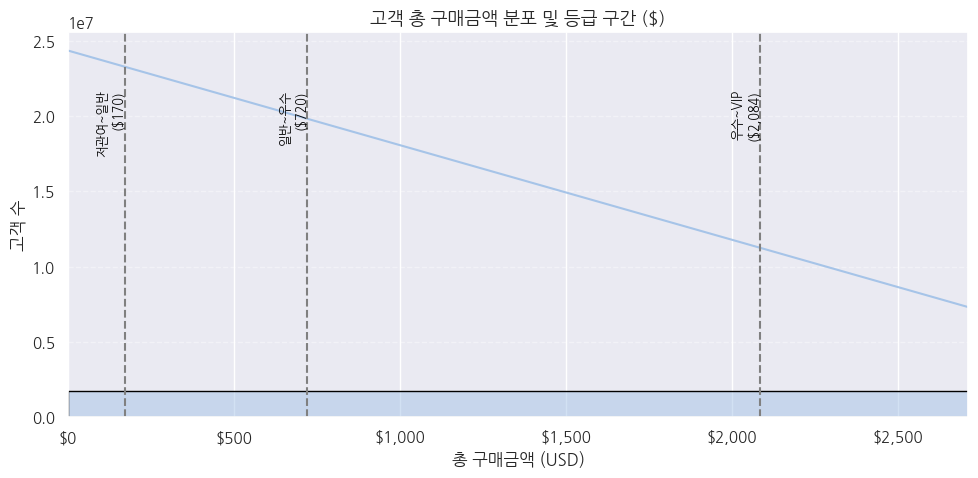

In [ ]:
import matplotlib.ticker as mtick

# 1. 사용자별 총 구매금액
total_spent = user_total['total_spent']

# 2. 등급 경계 계산 (30%, 70%, 90%)
quantile_edges = user_total['total_spent'].quantile([0.3, 0.7, 0.9]).round(2)
q30, q70, q90 = quantile_edges[0.3], quantile_edges[0.7], quantile_edges[0.9]

# 3. 시각화 설정
plt.figure(figsize=(10, 5))
sns.histplot(total_spent, bins=40, kde=True, color='#a6c4e8', edgecolor='black')

# 4. 경계선 및 라벨 추가
grade_labels = ['저관여~일반', '일반~우수', '우수~VIP']
for i, (q, label) in enumerate(zip([q30, q70, q90], grade_labels)):
    plt.axvline(q, color='gray', linestyle='--')
    plt.text(q, plt.ylim()[1] * 0.85, f"{label}\n(${int(q):,})",
             rotation=90, va='top', ha='right', fontsize=9, color='black')

# 5. 축 포맷 및 제한
plt.xlim(0, q90 * 1.3)  # 이상치 제외하고 최대치를 VIP 경계보다 약간 크게 제한
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# 6. 제목 및 스타일
plt.title("고객 총 구매금액 분포 및 등급 구간 ($)", fontsize=13)
plt.xlabel("총 구매금액 (USD)")
plt.ylabel("고객 수")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# ✅ 유저별 이탈 여부 데이터셋 생성

In [ ]:
# -----------------------------------------------
# 1. 구매 이벤트만 필터링
# -----------------------------------------------
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# -----------------------------------------------
# 2. 사용자별 구매일 정렬 및 간격 계산
# -----------------------------------------------
df_purchase = df_purchase.sort_values(['user_id', 'event_time'])
df_purchase['prev_purchase'] = df_purchase.groupby('user_id')['event_time'].shift()
df_purchase['purchase_gap'] = (df_purchase['event_time'] - df_purchase['prev_purchase']).dt.days

# 평균 구매 간격
gap_df = df_purchase.groupby('user_id')['purchase_gap'].mean().reset_index()
gap_df.columns = ['user_id', 'avg_gap_days']

# 마지막 구매일
last_df = df_purchase.groupby('user_id')['event_time'].max().reset_index()
last_df.columns = ['user_id', 'last_purchase_date']

# 구매 횟수
purchase_counts = df_purchase.groupby('user_id').size().reset_index(name='purchase_count')

# -----------------------------------------------
# 3. 이탈 기준 계산 및 병합
# -----------------------------------------------
cutoff_date = pd.to_datetime(df['event_time'].max())  # 분석 기준일
multiplier = 1.5

# 병합
churn_df = last_df.merge(gap_df, on='user_id', how='left') \
                  .merge(purchase_counts, on='user_id', how='left')

# 평균 구매 간격이 없는 경우 전체 평균으로 대체
global_avg_gap = df_purchase['purchase_gap'].dropna().mean()
churn_df['avg_gap_days'] = churn_df['avg_gap_days'].fillna(0)

# 이탈 기준일 계산
churn_df['churn_threshold_date'] = churn_df['last_purchase_date'] + \
    pd.to_timedelta(churn_df['avg_gap_days'] * multiplier, unit='D')

# -----------------------------------------------
# 4. 이탈 여부 판단 (★ 핵심: 1회 구매자는 무조건 True)
# -----------------------------------------------
churn_df['is_churned'] = np.where(
    churn_df['purchase_count'] == 1,
    True,
    churn_df['churn_threshold_date'] < cutoff_date
)

# 결과: user_id별 이탈 정보
# churn_df[['user_id', 'purchase_count', 'avg_gap_days', 'last_purchase_date', 'churn_threshold_date', 'is_churned']]
churn_df

,user_id,last_purchase_date,avg_gap_days,purchase_count,churn_threshold_date,is_churned
0,101875240,2020-01-16 18:18:22+00:00,0.0,1,2020-01-16 18:18:22+00:00,True
1,107620212,2020-01-30 15:10:12+00:00,0.0,1,2020-01-30 15:10:12+00:00,True
2,128029678,2020-03-20 18:56:58+00:00,0.0,1,2020-03-20 18:56:58+00:00,True
3,128968633,2020-03-07 06:28:56+00:00,22.0,4,2020-04-09 06:28:56+00:00,False
4,136662675,2019-12-13 09:00:26+00:00,0.0,1,2019-12-13 09:00:26+00:00,True
...,...,...,...,...,...,...
1744359,635148377,2020-03-31 22:32:59+00:00,0.0,2,2020-03-31 22:32:59+00:00,True
1744360,635148505,2020-03-31 22:24:23+00:00,0.0,1,2020-03-31 22:24:23+00:00,True
1744361,635153043,2020-03-31 22:44:58+00:00,0.0,1,2020-03-31 22:44:58+00:00,True
1744362,635158569,2020-03-31 23:51:11+00:00,0.0,4,2020-03-31 23:51:11+00:00,True


In [ ]:
# 1. 이벤트 시간 변환
# df['event_time'] = pd.to_datetime(df['event_time'])

# 2. 유저별 최초 구매일 → tenure_days 계산
first_purchase = df[df['event_type'] == 'purchase'].groupby('user_id')['event_time'].min().reset_index()
first_purchase.columns = ['user_id', 'first_purchase_date']
cutoff_date = df['event_time'].max()
first_purchase['tenure_days'] = (cutoff_date - first_purchase['first_purchase_date']).dt.days

# 3. 유저별 total_views / total_carts
view_counts = df[df['event_type'] == 'view'].groupby('user_id').size().reset_index(name='total_views')
cart_counts = df[df['event_type'] == 'cart'].groupby('user_id').size().reset_index(name='total_carts')

# 4. view_to_cart_rate 계산
conversion = pd.merge(view_counts, cart_counts, on='user_id', how='outer').fillna(0)
conversion['view_to_cart_rate'] = np.where(
    conversion['total_views'] > 0,
    conversion['total_carts'] / conversion['total_views'],
    0
)

# 5. cart_to_purchase_rate 계산
cart_user = df[df['event_type'] == 'cart'].groupby('user_id').size().reset_index(name='cart_count')
purchase_user = df[df['event_type'] == 'purchase'].groupby('user_id').size().reset_index(name='purchase_count')
purchase_conversion = pd.merge(cart_user, purchase_user, on='user_id', how='outer').fillna(0)
purchase_conversion['cart_to_purchase_rate'] = np.where(
    purchase_conversion['cart_count'] > 0,
    purchase_conversion['purchase_count'] / purchase_conversion['cart_count'],
    0
)

# 6. most_frequent_category 추출 (가장 많이 구매한 카테고리)
most_cat = (
    df[df['event_type'] == 'purchase']
    .groupby(['user_id', 'category_lvl1'])
    .size()
    .reset_index(name='cnt')
    .sort_values(['user_id', 'cnt'], ascending=[True, False])
    .drop_duplicates('user_id')[['user_id', 'category_lvl1']]
    .rename(columns={'category_lvl1': 'most_frequent_category'})
)

# 7. activity_span_days 계산
activity = df.groupby('user_id')['event_time'].agg(['min', 'max']).reset_index()
activity['activity_span_days'] = (activity['max'] - activity['min']).dt.days
activity = activity[['user_id', 'activity_span_days']]

# 8. 모든 파생 컬럼 병합
churn_df_new = churn_df.merge(first_purchase[['user_id', 'tenure_days']], on='user_id', how='left') \
                   .merge(conversion[['user_id', 'total_views', 'total_carts', 'view_to_cart_rate']], on='user_id', how='left') \
                   .merge(purchase_conversion[['user_id', 'cart_to_purchase_rate']], on='user_id', how='left') \
                   .merge(most_cat, on='user_id', how='left') \
                   .merge(activity, on='user_id', how='left')
churn_df_new

,user_id,last_purchase_date,avg_gap_days,purchase_count,churn_threshold_date,is_churned,tenure_days,total_views,total_carts,view_to_cart_rate,cart_to_purchase_rate,most_frequent_category,activity_span_days
0,101875240,2020-01-16 18:18:22+00:00,0.0,1,2020-01-16 18:18:22+00:00,True,75,16.0,3.0,0.187500,0.333333,construction,20
1,107620212,2020-01-30 15:10:12+00:00,0.0,1,2020-01-30 15:10:12+00:00,True,61,103.0,4.0,0.038835,0.250000,sport,99
2,128029678,2020-03-20 18:56:58+00:00,0.0,1,2020-03-20 18:56:58+00:00,True,11,92.0,2.0,0.021739,0.500000,NaN,116
3,128968633,2020-03-07 06:28:56+00:00,22.0,4,2020-04-09 06:28:56+00:00,False,91,866.0,29.0,0.033487,0.137931,sport,140
4,136662675,2019-12-13 09:00:26+00:00,0.0,1,2019-12-13 09:00:26+00:00,True,109,65.0,2.0,0.030769,0.500000,construction,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744359,635148377,2020-03-31 22:32:59+00:00,0.0,2,2020-03-31 22:32:59+00:00,True,0,13.0,2.0,0.153846,1.000000,construction,0
1744360,635148505,2020-03-31 22:24:23+00:00,0.0,1,2020-03-31 22:24:23+00:00,True,0,6.0,1.0,0.166667,1.000000,appliances,0
1744361,635153043,2020-03-31 22:44:58+00:00,0.0,1,2020-03-31 22:44:58+00:00,True,0,2.0,1.0,0.500000,1.000000,construction,0
1744362,635158569,2020-03-31 23:51:11+00:00,0.0,4,2020-03-31 23:51:11+00:00,True,0,31.0,5.0,0.161290,0.800000,apparel,0


| 컬럼명                          | 설명                          |
| ---------------------------- | --------------------------- |
| `tenure_days`                | 고객 생애주기 (최초 구매일부터 cutoff까지) |
| `total_views`, `total_carts` | 행동량 지표                      |
| `view_to_cart_rate`          | 탐색 → 장바구니 전환율               |
| `cart_to_purchase_rate`      | 장바구니 → 구매 전환율               |
| `most_frequent_category`     | 가장 많이 구매한 대표 카테고리           |
| `activity_span_days`         | 활동 지속 기간 (최초 \~ 최후 이벤트 간격)  |


# ✅ 카테고리별 이탈율

In [ ]:
# -----------------------------------------------
# 1. 구매 이벤트만 필터링
# -----------------------------------------------
df_purchase = df[df['event_type'] == 'purchase'].copy()
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# -----------------------------------------------
# 2. 구매 간격 및 마지막 구매일 계산
# -----------------------------------------------
df_purchase = df_purchase.sort_values(['user_id', 'event_time'])
df_purchase['prev_purchase'] = df_purchase.groupby('user_id')['event_time'].shift()
df_purchase['purchase_gap'] = (df_purchase['event_time'] - df_purchase['prev_purchase']).dt.days

# 평균 재구매 간격
gap_df = df_purchase.groupby('user_id')['purchase_gap'].mean().reset_index()
gap_df.columns = ['user_id', 'avg_gap_days']

# 마지막 구매일
last_df = df_purchase.groupby('user_id')['event_time'].max().reset_index()
last_df.columns = ['user_id', 'last_purchase_date']

# 구매 횟수
purchase_counts = df_purchase.groupby('user_id').size().reset_index(name='purchase_count')

# -----------------------------------------------
# 3. 개인화된 이탈 기준 계산
# -----------------------------------------------
cutoff_date = pd.to_datetime(df['event_time'].max())  # 분석 기준일
multiplier = 1.5

# 병합
churn_df = last_df.merge(gap_df, on='user_id', how='left') \
                  .merge(purchase_counts, on='user_id', how='left')

# NaN → 전체 평균으로 대체
global_avg_gap = df_purchase['purchase_gap'].dropna().mean()
churn_df['avg_gap_days'] = churn_df['avg_gap_days'].fillna(global_avg_gap)

# 이탈 기준일 계산
churn_df['churn_threshold_date'] = churn_df['last_purchase_date'] + \
    pd.to_timedelta(churn_df['avg_gap_days'] * multiplier, unit='D')

# 이탈 여부 판단
churn_df['is_churned'] = np.where(
    churn_df['purchase_count'] == 1,
    True,
    churn_df['churn_threshold_date'] < cutoff_date
)

# -----------------------------------------------
# 4. 대표 카테고리 추출 (최다 구매 카테고리)
# -----------------------------------------------
user_cat = (
    df_purchase.groupby(['user_id', 'category_lvl1'])
    .size()
    .reset_index(name='purchase_count')
)

user_main_cat = (
    user_cat.sort_values(['user_id', 'purchase_count'], ascending=[True, False])
    .drop_duplicates('user_id')[['user_id', 'category_lvl1']]
)

# 병합
churn_df = churn_df.merge(user_main_cat, on='user_id', how='left')

# -----------------------------------------------
# 5. 카테고리별 이탈률 집계
# -----------------------------------------------
category_churn = (
    churn_df.groupby('category_lvl1')['is_churned']
    .agg(['count', 'sum', 'mean'])
    .reset_index()
    .rename(columns={
        'count': 'num_users',
        'sum': 'num_churned',
        'mean': 'churn_rate'
    })
    .sort_values('churn_rate', ascending=False)
)

# 결과 출력
category_churn


,category_lvl1,num_users,num_churned,churn_rate
7,electronics,381987,356911,0.934354
12,stationery,423,386,0.912530
10,medicine,522,471,0.902299
9,kids,18375,16543,0.900299
11,sport,60602,54053,0.891934
8,furniture,41384,36632,0.885173
5,construction,576830,507818,0.880360
3,auto,17096,14889,0.870905
4,computers,54129,46775,0.864139
6,country_yard,1620,1369,0.845062


### 주말여부 판단(0, 1)

In [ ]:
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)  # 주말 여부
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday,spending_grade,is_weekend
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,2019-10-01,5,None,None,None,None,Tuesday,저관여,0
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-10-01,5,appliances,environment,water_heater,None,Tuesday,미구매,0
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,2019-10-01,5,furniture,living_room,sofa,None,Tuesday,미구매,0
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,2019-10-01,5,computers,notebook,None,None,Tuesday,미구매,0
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,2019-10-01,5,electronics,smartphone,None,None,Tuesday,미구매,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345120463,2020-03-31 23:59:55+00:00,view,1005212,2232732093077520756,construction.tools.light,samsung,178.12,516506125,cdd4bce1-ff8c-49c3-92b3-0c7a209c8b24,2020-04-01,4,construction,tools,light,None,Wednesday,일반,0
345120464,2020-03-31 23:59:55+00:00,view,1701027,2232732099981345295,appliances.personal.massager,samsung,154.42,572260610,2e16ffb5-996f-40d3-b98e-ddc53b546357,2020-04-01,4,appliances,personal,massager,None,Wednesday,미구매,0
345120465,2020-03-31 23:59:56+00:00,view,2601488,2232732101835227701,None,darina,167.29,523607693,6836d271-ef67-42dc-8756-4ef103e4fbf1,2020-04-01,4,None,None,None,None,Wednesday,우수,0
345120466,2020-03-31 23:59:56+00:00,view,100006963,2232732099754852875,appliances.personal.massager,yasin,163.16,629229484,c00a1636-dfc2-4e96-a6a3-7fd979e93789,2020-04-01,4,appliances,personal,massager,None,Wednesday,VIP,0


In [ ]:
# 세션별 체류 시간, 이벤트 수 등
df = df.sort_values(by=['user_id', 'user_session', 'event_time'])

# 세션 종료 시간 - 시작 시간
session_time = df.groupby(['user_id', 'user_session'])['event_time'].agg(['min', 'max'])
session_time['session_duration_sec'] = (session_time['max'] - session_time['min']).dt.total_seconds()
session_time = session_time[['session_duration_sec']].reset_index()

# 병합
df = pd.merge(df, session_time, on=['user_id', 'user_session'], how='left')
df


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday,spending_grade,is_weekend,session_duration_sec
0,2019-11-06 06:51:52+00:00,view,26300219,2053013563424899933,None,sokolov,40.54,10300217,d1fdcbf1-bb1f-434b-8f1a-4b77f29a84a0,2019-11-06,11,None,None,None,None,Wednesday,미구매,0,0.0
1,2020-03-08 17:23:57+00:00,view,100042492,2053013566142809077,construction.tools.generator,fissman,17.63,12511517,50559412-c7a9-4a9d-80c2-f36f16278604,2020-03-08,22,construction,tools,generator,None,Sunday,미구매,1,0.0
2,2020-02-24 05:52:05+00:00,view,38900019,2053013558987326060,apparel.shoes.moccasins,None,100.39,12511517,c19cb076-f4c4-4fed-9bb3-8657eb3ff3b0,2020-02-24,10,apparel,shoes,moccasins,None,Monday,미구매,0,0.0
3,2020-02-14 03:37:37+00:00,view,28711661,2232732074815521775,computers.peripherals.mouse,rieker,50.19,22165363,0237b95e-83cf-45e4-ba15-59f0bfbbd8c4,2020-02-14,8,computers,peripherals,mouse,None,Friday,미구매,0,0.0
4,2020-02-12 08:18:06+00:00,view,26601499,2232732081895506036,furniture.bedroom.bed,aquamarine,15.83,22165363,55efe202-f6a9-435c-b21c-2add70f949d4,2020-02-12,13,furniture,bedroom,bed,None,Wednesday,미구매,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345120463,2020-03-31 23:58:20+00:00,view,1307054,2053013554658804075,electronics.audio.headphone,apple,1441.20,635166288,5c10fae7-ee7a-4c4d-96a5-5f8b8878fd57,2020-04-01,4,electronics,audio,headphone,None,Wednesday,미구매,0,0.0
345120464,2020-03-31 23:58:26+00:00,view,13200697,2232732061804790604,furniture.bedroom.bed,redford,170.40,635166308,44c67e08-98fa-42e2-a3cd-7324dd38e72c,2020-04-01,4,furniture,bedroom,bed,None,Wednesday,미구매,0,0.0
345120465,2020-03-31 23:59:38+00:00,view,4804660,2232732079706079299,sport.bicycle,xiaomi,24.45,635166327,1bc34461-44ad-41e8-8ac0-067642e93c9a,2020-04-01,4,sport,bicycle,None,None,Wednesday,미구매,0,0.0
345120466,2020-03-31 23:59:09+00:00,view,13201276,2232732061804790604,furniture.bedroom.bed,None,100.39,635166340,f94c2c0d-abee-4a9b-ad1b-47b85b57c036,2020-04-01,4,furniture,bedroom,bed,None,Wednesday,미구매,0,43.0
